**Load the required data and libraries**

In [1]:
# Libraries  
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings 

warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline

In [2]:
# Data 
df = pd.read_csv("../data/PLP Patient Lifetime Profile.csv", 
                             encoding='UTF-16', delimiter="\t")

appointment_df = pd.read_csv("../data/Appointments List.csv", 
                             encoding='UTF-16', delimiter="\t")

# INTRODUCTION

In a recent look at appointment trends over time, we noticed a concerning drop in MH infusion rates starting around mid-2023, which worsened as we entered 2024. This raised an important question: Could payments be influencing why some patients stopped coming back?

**Objectives**

The goal of this project was to dive deeper and uncover:

Whether the cost of services played a role in patients leaving.
How well we’re retaining our patients over time.
If rising costs could be the main reason some patients are no longer returning.


# EXPLANATORY DATA ANALYSIS 
## Data Assessment 

In [3]:
df.head()

,Patient FID,ChartNumber,ZipCode (tmtPLPPatientLifeTimeProfile),CreatedDate,First Date Of Service,Last Date Of Service,Last Primary Appt Type Group,Last Facility City,Days Since Last DoS dim,Next Scheduled Appt Date,...,Total Insurance Payments,Total Patient Payments,Total Writeoff Amount,Charge Code Count,Diagnosis Code Count,Vists / Months Span,OutstandingAR,Count of tmtPLPPatientLifeTimeProfile,SeenProvidersCount,PatientsWithVisit%
0,Grand Total,Total,Total,Total,Total,Total,Total,Total,Total,Total,...,"$1,240,855.95","$14,861,653.28","$995,613.48","8,024","3,473","6,599.64","$1,388,296.81","1,602",0,99.94%
1,5283,1,02139,01/22/18,01/22/18,05/29/18,TMS,CAMBRIDGE,2366,NaN,...,"$6,147.36","$3,464.68","$6,187.96",4,1,12.75,"$6,147.36",1,0,100.00%
2,5286,2,02118,01/23/18,01/16/18,06/27/18,MH Infusion,CAMBRIDGE,2337,NaN,...,NaN,"$4,450.00",NaN,2,1,2.60,$0.00,1,0,100.00%
3,5287,3,02474,01/23/18,01/29/18,02/13/18,MH Infusion,CAMBRIDGE,2471,NaN,...,NaN,"$3,400.00",NaN,2,1,7.00,$0.00,1,0,100.00%
4,5347,5,02127,01/23/18,01/25/18,03/27/18,MH Infusion,CAMBRIDGE,2429,NaN,...,NaN,"$3,900.00",NaN,2,1,4.50,$0.00,1,0,100.00%


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1603 entries, 0 to 1602
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   Patient FID                             1603 non-null   object
 1   ChartNumber                             1603 non-null   object
 2   ZipCode (tmtPLPPatientLifeTimeProfile)  1603 non-null   object
 3   CreatedDate                             1603 non-null   object
 4   First Date Of Service                   1603 non-null   object
 5   Last Date Of Service                    1603 non-null   object
 6   Last Primary Appt Type Group            1501 non-null   object
 7   Last Facility City                      1469 non-null   object
 8   Days Since Last DoS dim                 1603 non-null   object
 9   Next Scheduled Appt Date                144 non-null    object
 10  Financial Class                         1603 non-null   object
 11  Seen

## Data Preparation

Before diving into the analysis, the data underwent some careful cleaning and organization to ensure accuracy. Here’s what was done:

1. **Removed an irrelevant record:** The very first record was inaccurate and unnecessary, so it was excluded from the analysis.
2. **Standardized appointment statuses:** To keep things consistent, all "Made" appointments were categorized as "Seen," focusing only on successful appointments for analysis.
3. **Cleaned up patient IDs:** Any extra spaces in chart numbers were removed, and all IDs were converted to a consistent format for easy comparison between the appointments and patient lifetime datasets.
4. **Formatted dates:** Dates across the datasets were standardized into a recognizable format for smoother processing.

With these steps, the data was ready for the next stage—analyzing patient payments over time. Additional adjustments may be made as needed during the analysis process.

In [5]:
# drop the first row 
df.drop(index=0, inplace=True)
df.reset_index(drop=True, inplace=True)

# Clean the appointment data set 
## Replace "Made" to "Seen"
appointment_df["Appt Status Description"].replace("Made", "Seen", inplace=True)
## Delete the first  and second rows 
appointment_df.drop(index=[0, 1], inplace=True)
appointment_df.reset_index(inplace=True, drop=True)

# Convert chart numbers to integers to deal with white spaces  
## PLP data 
plp_chartnumbers = [int(chart_number) for chart_number in df["ChartNumber"]]
df["ChartNumber"] = plp_chartnumbers

##  Appointment data 
appt_chartnumbers = [int(chart_number) for chart_number in appointment_df["Chartnumber"]]
appointment_df["Chartnumber"] = appt_chartnumbers

# Convert the datetime like variables to datetime 
df["CreatedDate"] = pd.to_datetime(df["CreatedDate"], errors="coerce")
df["First Date Of Service"] = pd.to_datetime(df["First Date Of Service"], errors="coerce")
df["Last Date Of Service"] = pd.to_datetime(df["Last Date Of Service"], errors="coerce")


## Data Analysis and Visualization

**Ideas for Analysis**

To uncover meaningful insights, the data was segmented into the following patient groups:

- **Patients Before Mid-2023:** Those who concluded their services before mid-2023 (`patients_before_mid2023`).
- **Late 2023 Patients:** Those who began their services after mid-2023 but concluded before 2024 (`patients_late_2023`).
- **All-Time Patients:** Those whose services spanned from before mid-2023 and continued into 2024 (`all_time_patients`).
- **2024 Patients**: Those whose services occurred exclusively in 2024 (`patients_2024`). This group is especially crucial as the MH infusion drop was observed to steepen in 2024.

The analysis aims to explore the following areas:

- The role of insurance and its offerings to patients.
- The proportion of expenses covered by insurance versus the amount paid out-of-pocket by patients.
- The total cost incurred by patients for their services.
- Pay-per-visit trends, focusing specifically on successful appointments.

By breaking down the data in this way, the goal is to identify patterns and uncover any potential links between costs and patient behavior.

**Split the patients into four categories**

In [6]:
decided_date = pd.to_datetime("2023-07-01") # mid-2023
begin_2024 = pd.to_datetime("2024-01-01") # begining 2024

# Ones who had their last day in service before mid-2023 as patients_before_mid2023
patients_before_mid2023 = df[df["Last Date Of Service"]<decided_date].reset_index(drop=True)

# Ones who had their first day of service but before 2024
patients_late_2023 = df[(df["First Date Of Service"]>=decided_date)&
                           (df["Last Date Of Service"]<begin_2024)].reset_index(drop=True)

# Special
## Ones who had their first day of service from the beginning of 2024
patients_2024 = df[df["First Date Of Service"]>=begin_2024].reset_index(drop=True)

# Ones who had their services run throughout before through to 2024 as all_time_patients
all_time_patients = df[(df["First Date Of Service"]<decided_date)\
                      &(df["Last Date Of Service"]>=begin_2024)].reset_index(drop=True)

### Insurance Analysis 

In [7]:
# Count the null values (Ratio of null values)
df["Total Insurance Payments"].isna().sum()/len(df)

0.8071161048689138

Upon reviewing the insurance data, it was found that approximately 80% of the entries were missing. Due to this significant gap, a meaningful analysis of insurance contributions was not possible.

As a result, the focus has shifted to analyzing the amount paid directly by each patient, which provides a clearer and more complete picture of the financial aspect of the services.

### Payment Analysis

As there was no enough data to find the effect of insurance, the patient's payment were to be analyzed.

**Assumptions**

Here are the assumptions that were made; 

- Every services was charged the same. 
- The cancelled appointments were not invoiced.

In [23]:
# count the null values (ration of null values)
df["Total Patient Payments"].isna().sum()/len(df)

0.031835205992509365

3% of the Patients payment data is null therefore we can go on with the analysis 

In [9]:
# Clean the data 
## Remove the "$" sign
## Deal with the null values 
## Convert the whole variable to numeric 

def clean_amount(amount):
    """
    Docstring 
    Here is how the total payments will be cleaned 
        - Remove the "$" sign
        - Deal with the null values 
        - Convert the whole variable to numeric 
    """
    
    if pd.isnull(amount):
        return None # Handle null values 
    
    # Remove "$" and commas
    amount = amount.replace("$", "").replace(",", "").strip()
    
    return float(amount)

# Test the function
clean_amount(df["Total Patient Payments"][0])

3464.68

In [10]:
# Apply the function to the "Total Patient Payments" column for each category

## ----- Run the below code once
patients_before_mid2023["Total Patient Payments"] = patients_before_mid2023["Total Patient Payments"].apply(clean_amount)
patients_late_2023["Total Patient Payments"] = patients_late_2023["Total Patient Payments"].apply(clean_amount)
all_time_patients["Total Patient Payments"] = all_time_patients["Total Patient Payments"].apply(clean_amount)
patients_2024["Total Patient Payments"] = patients_2024["Total Patient Payments"].apply(clean_amount)

**Distribution**

A distribution in data refers to how values are spread or arranged within a dataset. It provides insight into the frequency or likelihood of different outcomes or measurements occurring. By analyzing a distribution, we can understand patterns, such as what is typical, rare, or consistent. Distributions often reveal the overall structure of data, helping to identify averages, extremes, and trends. In essence, it is a way to summarize and visualize the nature of data, making it easier to interpret and make informed decisions based on the observed characteristics. In this analysis, we plotted distribution plot(blend of histogram and density plot) to show the distribution of the total payment per patients in each category. 

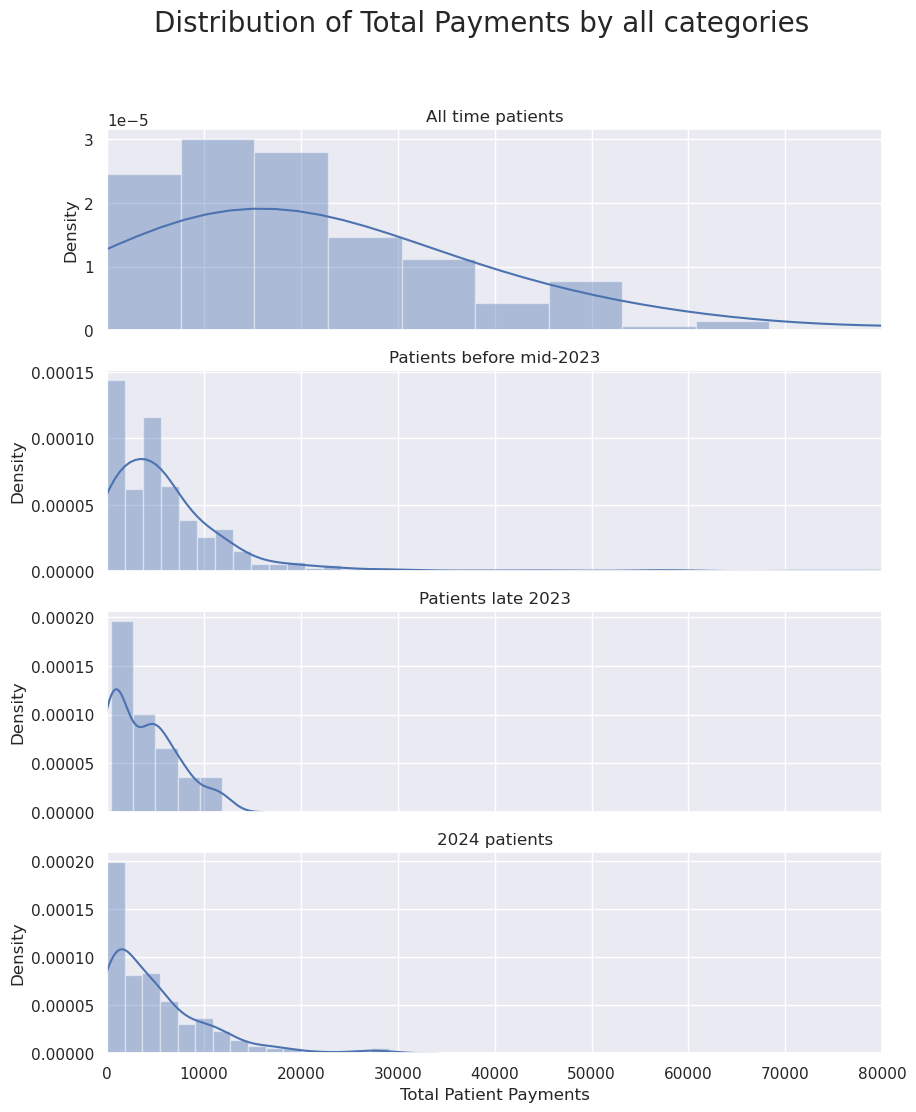

In [11]:
# Distribution of payments 

fig, axes = plt.subplots(nrows=4, ncols=1,
                        figsize=(10, 12), sharex=True)

# Total Patient Payments 
## All time patients 
sns.distplot(all_time_patients["Total Patient Payments"], ax = axes[0])
axes[0].set_title("All time patients")

## Before mid 2023
sns.distplot(patients_before_mid2023["Total Patient Payments"], ax = axes[1])
axes[1].set_title("Patients before mid-2023")

## After mid 2023
sns.distplot(patients_late_2023["Total Patient Payments"], ax = axes[2])
axes[2].set_title("Patients late 2023")

## 2024
sns.distplot(patients_2024["Total Patient Payments"], ax = axes[3])
axes[3].set_title("2024 patients")

plt.xlim(0, 80000)
plt.suptitle("Distribution of Total Payments by all categories", fontsize=20)
plt.show()

From the histograms above, it can be concluded that; 

* All the categories have similar shape of distribution. However, all-time patients(patients who existed before mid 2023 till 2024) had the highest total payment for their services. 
* Most of the all-time patients paid a total of between 10000 to 20000 dollars for all their payments. 
* All other categories had most of their patients pay below 5000 dollars for their services. 

The data set has values since the year 2018, therefore it can be assumed that all-time and 'before mid 2023' category patients existed for relatively longer(5 years at most). The 'late mid-2023' and '2024-patients' have existed for relatively shorter period, 6 months and one year respectively. This might be the reason why all-time patients paid more(total) that the later patients. 

The following next steps will be taken to dive deep into the issue of payment and find the difference between the categories:

 - Preprocess the data to get the actual number of visits
 - Calculate the patient's pay per appointment
 - Compute the distribution of the patient's pay per appointment
 
It is assumed that each successfull appointment was priced the same 

**Breakdown to pay per visit**

Before caclulating payper visit, here is how the data was preprocessed; 

- Selected all the successfull apointments
- Aggregated the total count of the successful appointments for each patients. 
- Calculated the pay per visit for each patient. 

In [12]:
# Prepare the data 
## Get all the successfull appointments 
seen_app_df = appointment_df[appointment_df["Appt Status Description"]=="Seen"].reset_index(drop=True)

## Count the number of appointments per patient 
appointments_per_patient = seen_app_df[["Chartnumber", "Appt Type Group"]].groupby("Chartnumber").count()

appointments_per_patient.reset_index(inplace=True)
appointments_per_patient.rename({"Appt Type Group":"appointment count"}, axis=1, inplace=True)

# Merge with the other PLP data sets and calculate pay per appointment
## Merge with patients before mid-2023
patients_before_mid2023 = patients_before_mid2023.merge(appointments_per_patient,
                                                        left_on="ChartNumber",
                                                        right_on="Chartnumber")
## Calculate pay per visit 
patients_before_mid2023["pay_per_visit"] = patients_before_mid2023["Total Patient Payments"]/\
patients_before_mid2023["appointment count"]

## Merge with patients late 2023
patients_late_2023 = patients_late_2023.merge(appointments_per_patient,
                                                      left_on="ChartNumber",
                                                      right_on="Chartnumber")

## Calculate pay per visit 
patients_late_2023["pay_per_visit"] = patients_late_2023["Total Patient Payments"]/\
patients_late_2023["appointment count"]

## Merge with all time patients 
all_time_patients = all_time_patients.merge(appointments_per_patient,
                                            left_on="ChartNumber",
                                            right_on="Chartnumber")

## Calculate pay per visit 
all_time_patients["pay_per_visit"] = all_time_patients["Total Patient Payments"]/\
all_time_patients["appointment count"]


## Merge with 2024 patients
patients_2024 = patients_2024.merge(appointments_per_patient,
                                    left_on="ChartNumber",
                                    right_on="Chartnumber")

## Calculate pay per visit 
patients_2024["pay_per_visit"] = patients_2024["Total Patient Payments"]/\
patients_2024["appointment count"]

## Remove all records with zero appointments 
patients_before_mid2023 = patients_before_mid2023[patients_before_mid2023["appointment count"]!=0]
patients_late_2023 = patients_late_2023[patients_late_2023["appointment count"]!=0]
all_time_patients = all_time_patients[all_time_patients["appointment count"]!=0]
patients_2024 = patients_2024[patients_2024["appointment count"]!=0]

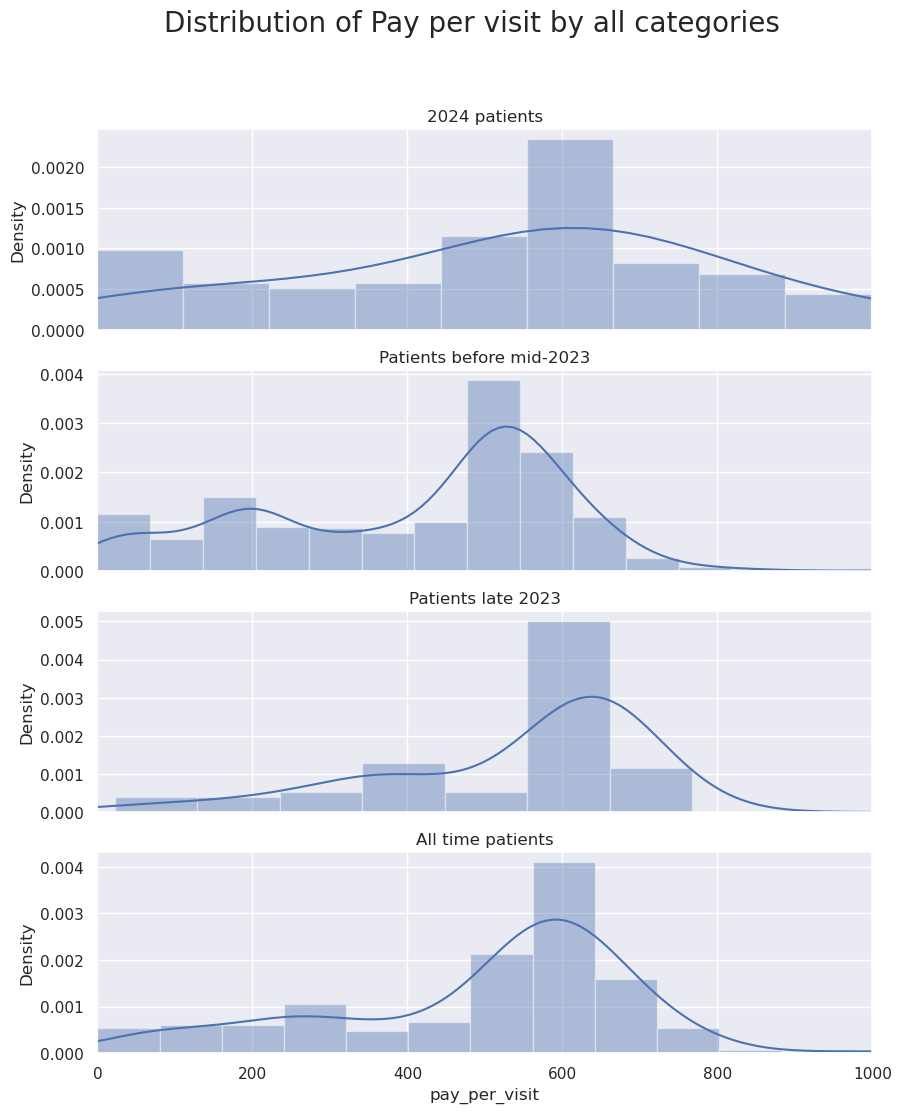

In [13]:
# Calculate the distribution of pay per visit

fig, axes = plt.subplots(nrows=4, ncols=1,
                        figsize=(10, 12), sharex=True)

# Total Patient Payments 
## 2024 patients 
sns.distplot(patients_2024["pay_per_visit"], ax = axes[0])
axes[0].set_title("2024 patients")

## Before mid 2023
sns.distplot(patients_before_mid2023["pay_per_visit"], ax = axes[1])
axes[1].set_title("Patients before mid-2023")

## After mid 2023
sns.distplot(patients_late_2023["pay_per_visit"], ax = axes[2])
axes[2].set_title("Patients late 2023")

## All time patients 
sns.distplot(all_time_patients["pay_per_visit"], ax = axes[3])
axes[3].set_title("All time patients")

plt.xlim(0, 1000)
plt.suptitle("Distribution of Pay per visit by all categories", fontsize=20)
plt.show()

The histograms above describe the distribution of pay per visit for all the categories. All the categories follow a normal distribution(slightly left-skewed), however most patients before 2023 paid the least. The distribution shows that "late 2023" and "2024" had most patients pay more than 600 dollars per visit. 

### Summary Statistics for the payments 

To get this exactly, lets calculate the median and mean(average) pay per visit for each category. 

In [14]:
# Compute the summary statistics
d1 = pd.DataFrame(all_time_patients["pay_per_visit"].describe())
d2 = pd.DataFrame(patients_before_mid2023["pay_per_visit"].describe())
d3 = pd.DataFrame(patients_late_2023["pay_per_visit"].describe())
d4 = pd.DataFrame(patients_2024["pay_per_visit"].describe())

# Concatenate the data frames and merge the rows 
d5 = pd.concat([d1, d2, d3, d4], 
               axis=1)
d5.columns = ["all_time", "before mid-2023", "late 2023", "2024"]


# Drop the max and min indices  and the quartiles 
d5.drop(index=['min', '25%', '75%', 'max', 'std'], inplace=True)

# Rename the remaining indices 
d5.index = ['count', 'mean', 'median']

# Show the data set 
d5

,all_time,before mid-2023,late 2023,2024
count,188.000000,846.000000,73.000000,265.000000
mean,499.840100,410.131706,549.336474,624.260872
median,563.397129,487.500000,609.375000,606.250000


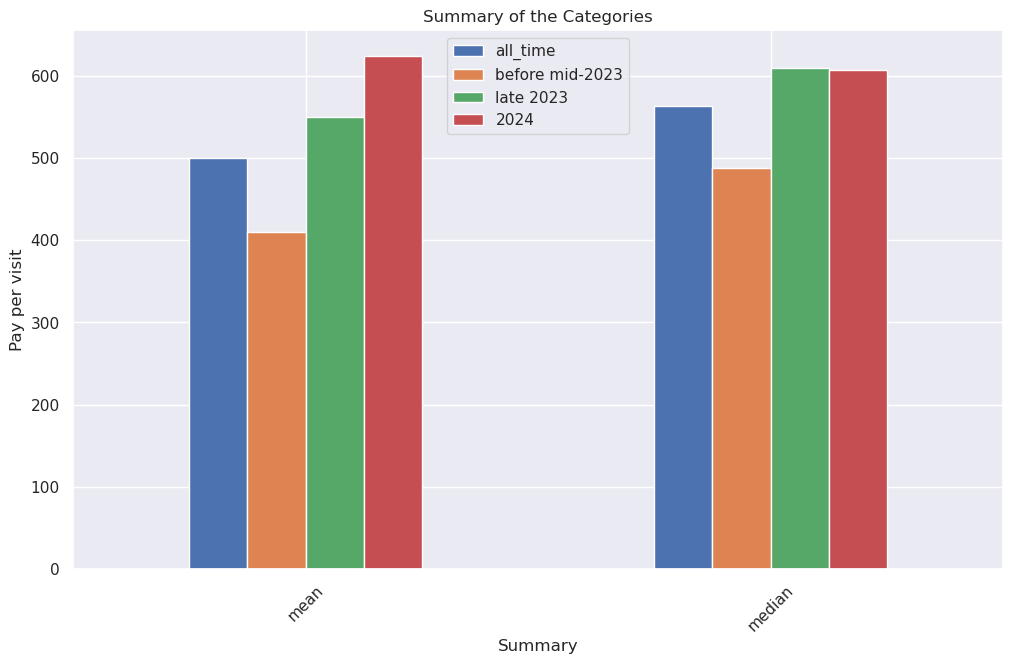

In [20]:
# Plot the data
d5.drop(index="count").plot(kind="bar", figsize=(12, 7), rot=45)
plt.title("Summary of the Categories")
plt.xlabel("Summary")
plt.ylabel("Pay per visit")
plt.legend(loc="upper center")

In [22]:
# d5.transpose().plot(kind="bar")
# # plt.ylim(200, 880)

# CONCLUSION 

This analysis highlights the change in payments charged per each patients category. Here is what waqs found out; 

* Patients before mid-2023 paid the least per visit
* Patients in the late 2023 and 2024 paid the highest
* Prices kept gradually increased from mid-2023. 


This is what I recommend you look into; 

- Are there any extra charges (unseen) to the patients introduced? 
- Is there inflation?
- Did the provision of services became more expensive from your end? 

I also think of looking into the reason why the 188 patients endured the increasing charges. (Maybe there is something special. 

Challenges

- I could not analyze particularly MH infusion since I did not have the data for the payment of MH Infusion, therefore I assumed is priced the same as the other services. 